# Linear Discriminant Analysis

Imagine you have 3 types of flowers (Iris setosa, versicolor, virginica).
  
Each flower is described by 4 numbers (sepal length, sepal width, petal length, petal width).
  
If you try to visualize them in 4D, it’s impossible. So, you want to reduce dimensions.
  
LDA asks:
“Can I find a new axis (a line, or a plane) where flowers of the same type cluster together, and flowers of different types spread apart as much as possible?”
  
So, LDA is supervised → it uses the labels (species) while finding directions.

| Feature     | PCA                                      | LDA                                                                           |
| ----------- | ---------------------------------------- | ----------------------------------------------------------------------------- |
| Goal        | Maximize variance in projection          | Maximize class separation                                                     |
| Supervision | Unsupervised (ignores labels)            | Supervised (uses labels)                                                      |
| Projection  | Keeps directions of max variance in data | Keeps directions that maximize between-class variance / within-class variance |
| Axes        | Principal Components (PCs)               | Linear Discriminants (LDs)                                                    |
| Result      | Best representation of data structure    | Best separation of classes                                                    |


### Difference in code implementation:

- PCA would do:  
  
eig_vals, eig_vecs = np.linalg.eig(np.cov(X.T))
  
It only looks at variance of all features, no labels.

- LDA does:
  
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
  
It builds scatter matrices S_W (within-class) and S_B (between-class) using class labels.

- So in PCA, the “axes” depend only on how spread out the data is.
- In LDA, the “axes” depend on how well they separate the labels.

## Key Assumptions of LDA
For LDA to perform effectively, certain assumptions are made:
  
- Gaussian Distribution: The data in each class should follow a normal bell-shaped distribution.
- Equal Covariance Matrices: All classes should have the same covariance structure.
- Linear Separability: The data should be separable using a straight line or plane.

In [44]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Load the Iris Dataset
iris = sns.load_dataset('iris')
# Create a DataFrame from the dataset
iris_df = pd.DataFrame(iris)

In [46]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [47]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [48]:
iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


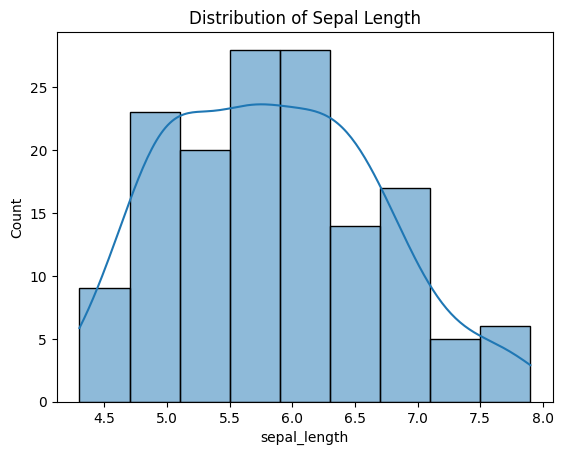

In [49]:
# Checking if distribution of the iris dataset is normal
sns.histplot(iris_df['sepal_length'], kde=True)
plt.title('Distribution of Sepal Length')
plt.show()


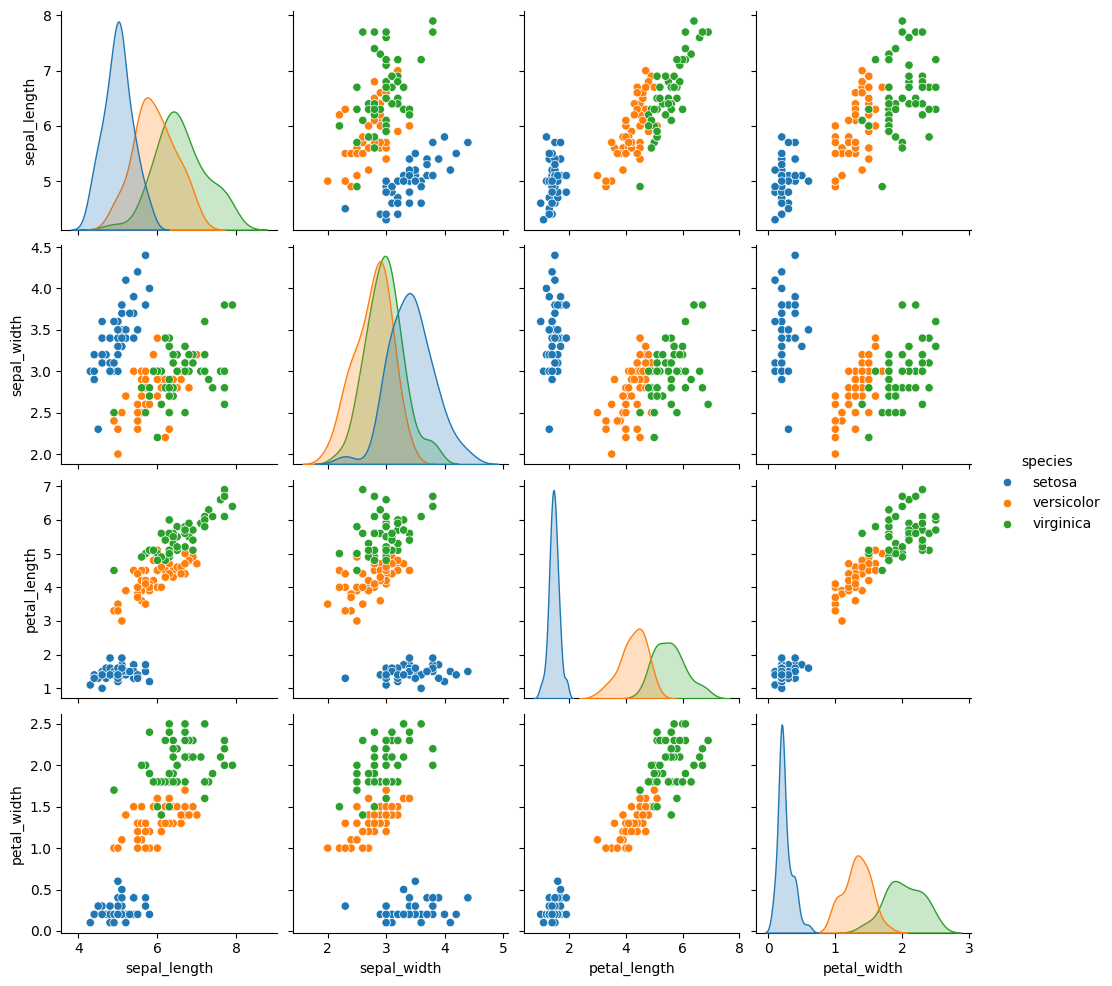

In [50]:
# Checking if The iris dataset is linearly separable
sns.pairplot(iris_df, hue='species')
plt.show()

- LDA uses both axes (X and Y) to generate a new axis in such a way that it maximizes the distance between the means of the two classes while minimizing the variation within each class. 
- This transforms the dataset into a space where the classes are better separated. After transforming the data points along a new axis LDA maximizes the class separation. 
- This new axis allows for clearer classification by projecting the data along a line that enhance the distance between the means of the two classes.

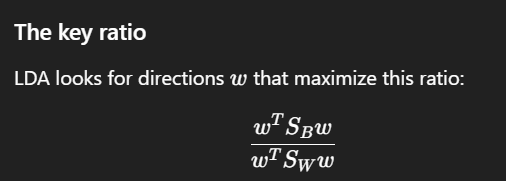

## Step 1: Computing Class Means

### What is a class mean?
Take one class (say, setosa). For each feature, average its values over all setosa samples.

### Why do we need them?
LDA compares:

Within-class scatter (how spread out each class is around its own mean) → Sw
  
Between-class scatter (how far class means are from the overall mean) → SB
  
Then it finds directions that make between big and within small.

In [51]:
# Step 1: Computing Class Means
class_means = iris_df.groupby('species').mean()
# Print the class means:
print(class_means)

            sepal_length  sepal_width  petal_length  petal_width
species                                                         
setosa             5.006        3.428         1.462        0.246
versicolor         5.936        2.770         4.260        1.326
virginica          6.588        2.974         5.552        2.026


## Step 2: Compute within class scatter matrix

In [52]:
# Step 2: Compute within class scatter matrix
def within_class_scatter_matrix(iris_df):
    classes = iris_df['species'].unique()
    n_features = iris_df.shape[1] - 1  # Exclude the target variable
    S_w = np.zeros((n_features, n_features))
    
    for cls in classes:
        class_data = iris_df[iris_df['species'] == cls].iloc[:, :-1].values
        mean_vector = np.mean(class_data, axis=0)
        scatter_matrix = np.cov(class_data, rowvar=False)
        S_w += scatter_matrix * (class_data.shape[0] - 1)
    
    return S_w

## Step 3: Compute between class scatter matrix

In [53]:
# Step 3: Compute between class scatter matrix
def between_class_scatter_matrix(iris_df, class_means):
    overall_mean = np.mean(iris_df.iloc[:, :-1].values, axis=0)
    classes = iris_df['species'].unique()
    n_features = iris_df.shape[1] - 1  # Exclude the target variable
    S_b = np.zeros((n_features, n_features))

    for cls in classes:
        n_cls = iris_df[iris_df['species'] == cls].shape[0]
        mean_vector = class_means.loc[cls].values
        S_b += n_cls * np.outer(mean_vector - overall_mean, mean_vector - overall_mean)

    return S_b

In [54]:
# Implementing within class scatter matrix and between class scatter matrix on the Iris dataset
class_means = iris_df.groupby('species').mean()
S_w = within_class_scatter_matrix(iris_df)
S_b = between_class_scatter_matrix(iris_df, class_means)

# Print within class scatter matrix and between class scatter matrix
print("Within Class Scatter Matrix:")
print(S_w)
print("\nBetween Class Scatter Matrix:")
print(S_b)


Within Class Scatter Matrix:
[[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]

Between Class Scatter Matrix:
[[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


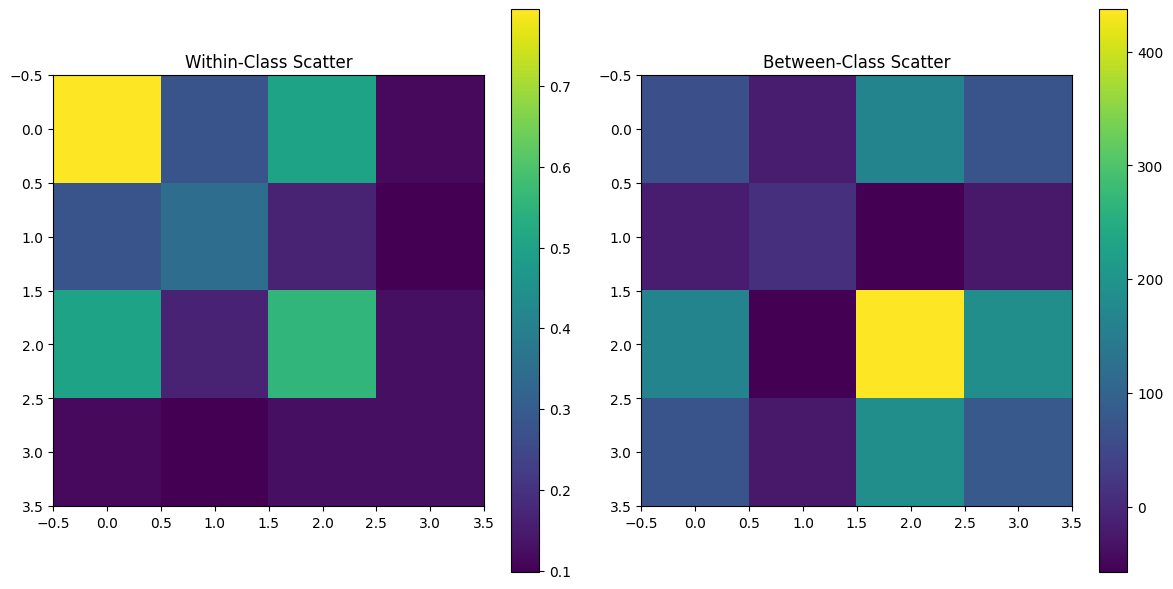

In [56]:
# Visualizing the within class scatter and between class scatter
plt.figure(figsize=(12, 6))
# Compute the within-class scatter matrix
S_W = np.zeros((X.shape[1], X.shape[1]))
for c in np.unique(y):
    X_c = X[y == c]
    S_W += np.cov(X_c, rowvar=False)
# Compute the between-class scatter matrix
mean_overall = np.mean(X, axis=0)
S_B = np.zeros((X.shape[1], X.shape[1]))
for c in np.unique(y):
    X_c = X[y == c]
    n_c = X_c.shape[0]
    mean_c = np.mean(X_c, axis=0)
    S_B += n_c * np.outer(mean_c - mean_overall, mean_c - mean_overall)
# Plotting
plt.subplot(1, 2, 1)
plt.title("Within-Class Scatter")
plt.imshow(S_W, cmap='viridis')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Between-Class Scatter")
plt.imshow(S_B, cmap='viridis')
plt.colorbar()
plt.tight_layout()
plt.show()

## Step 4: Solve the Eigen Value Problem

In [57]:
# Step 4: Solve the Eigen Value Problem
from scipy.linalg import eigh
eig_vals, eig_vecs = eigh(S_b, S_w)
# Print the Eigen Values and Eigen Vectors
print("Eigen Values:")
print(eig_vals)
print("\nEigen Vectors:")
print(eig_vecs)

Eigen Values:
[-4.65533671e-15  8.92969536e-15  2.85391043e-01  3.21919292e+01]

Eigen Vectors:
[[ 0.17803036 -0.19335797  0.00198791  0.06840592]
 [-0.01648972  0.22060752  0.1785267   0.12656121]
 [-0.00313204  0.24845032 -0.07686357 -0.18155288]
 [-0.15523614 -0.34276051  0.23417227 -0.23180286]]


## Step 5: Sort Eigen Values by Eigen Vectors and pick the top (k-1) classes

In [58]:
# Step 6: Sort Eigen values by Eigen values in descending order
sorted_indices = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sorted_indices]
eig_vecs = eig_vecs[:, sorted_indices]
# Pick the top (k-1) eigenvectors
k = 2  # Number of classes - 1
W = eig_vecs[:, :k]

## Step 6: Project this data onto new axes

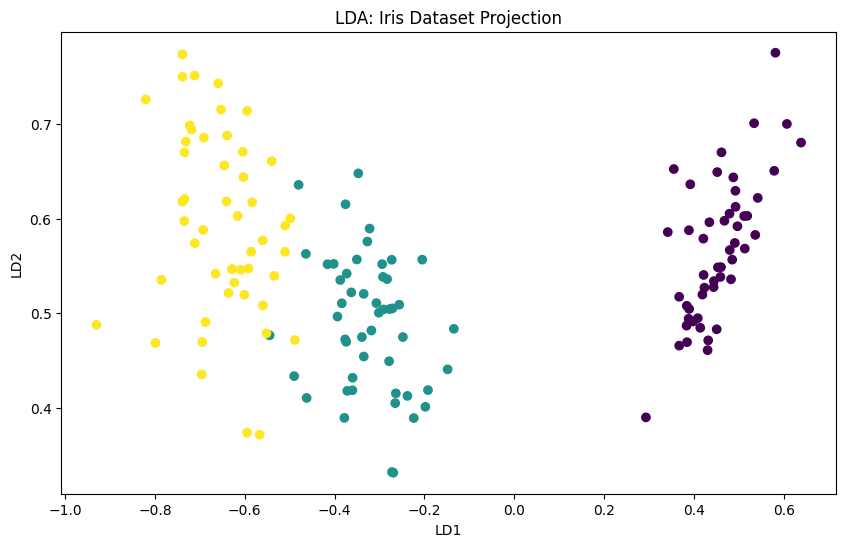

In [59]:
# Step 7: Project the data onto the new feature space
X_lda = iris_df.iloc[:, :-1].values.dot(W)

# Visualize the new projection
plt.figure(figsize=(10, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=pd.factorize(iris_df['species'])[0], cmap='viridis')
plt.title("LDA: Iris Dataset Projection")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.show()

## Implementing LDA using scikit learn and comparing the results

Accuracy on test set: 1.0


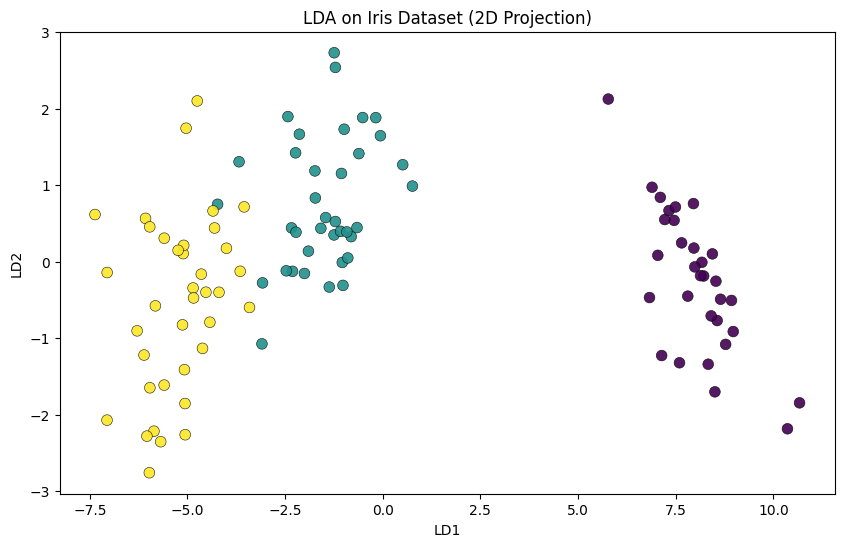

In [60]:
# Implementing LDA on the Iris Dataset using scikit learn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load Iris dataset
iris = datasets.load_iris()
X = iris.data   # features
y = iris.target # labels

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit LDA model
lda = LinearDiscriminantAnalysis(n_components=2)  # reduce to 2D for visualization
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Train accuracy
y_pred = lda.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

# Plot the transformed features to match the manual LDA projection style (viridis colormap)
plt.figure(figsize=(10, 6))
# match marker size and style used earlier, remove colorbar for same look
plt.scatter(X_train_lda[:,0], X_train_lda[:,1], c=y_train, cmap='viridis', s=60, alpha=0.9, edgecolors='k', linewidths=0.4)
plt.title("LDA on Iris Dataset (2D Projection)")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.show()


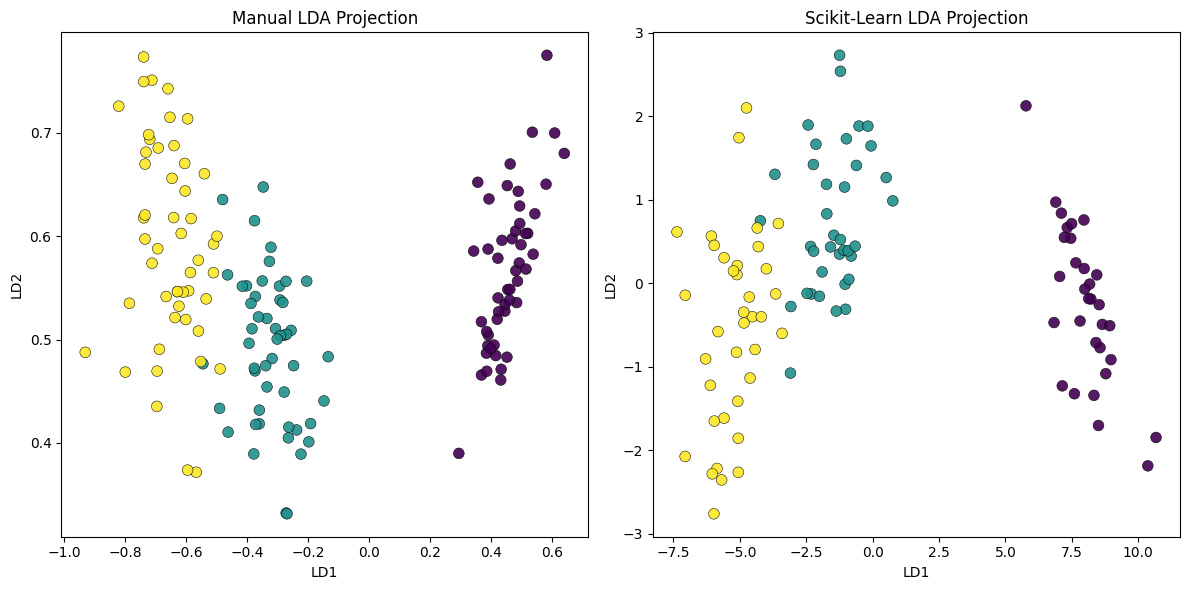

In [62]:
# Comparing the results of manual LDA and LDA using scikit learn
plt.figure(figsize=(12, 6))
# Left: manual LDA projection computed earlier (X_lda)
plt.subplot(1, 2, 1)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=pd.factorize(iris_df['species'])[0], cmap='viridis', s=60, alpha=0.9, edgecolors='k', linewidths=0.4)
plt.title("Manual LDA Projection")
plt.xlabel("LD1")
plt.ylabel("LD2")
# Right: scikit-learn LDA fitted on the full dataset for fair visual comparison
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_full = LinearDiscriminantAnalysis(n_components=2)
X_full = iris_df.iloc[:, :-1].values
y_full = pd.factorize(iris_df['species'])[0]
X_lda_sk = lda_full.fit_transform(X_full, y_full)
plt.subplot(1, 2, 2)
plt.scatter(X_train_lda[:,0], X_train_lda[:,1], c=y_train, cmap='viridis', s=60, alpha=0.9, edgecolors='k', linewidths=0.4)
plt.title("Scikit-Learn LDA Projection")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.tight_layout()
plt.show()